In [50]:
import numpy as np
import pandas as pd
import scipy as sp
import matplotlib.pyplot as plt
import evidential_deep_learning as edl
import tensorflow as tf
import keras as ks
import time
import functools

In [56]:
# Load the data and break it up into the test + train sets
trainDF = pd.read_csv('C:\\Users\\sumee\\Downloads\\updated_medical_train.csv')
testDF = pd.read_csv('C:\\Users\\sumee\\Downloads\\updated_medical_test.csv')
validateDF = pd.read_csv('C:\\Users\\sumee\\Downloads\\updated_medical_validate.csv')



X_train = trainDF.drop(columns=['Medical Cost'])
X_train = X_train.replace({True: 1, False: 0})
X_train = tf.convert_to_tensor(X_train.values)
y_train = trainDF['Medical Cost'].to_frame()
y_train = tf.convert_to_tensor(y_train.values)


X_test = testDF.drop(columns=['Medical Cost'])
X_test = X_test.replace({True: 1, False: 0})
X_test = tf.convert_to_tensor(X_test.values)
y_test = testDF['Medical Cost'].to_frame()


#X_train = X_train.to_numpy()#np.random.rand(1000, 9)  # 1000 samples, 9 features
#y_train = y_train.to_numpy()#np.random.rand(1000, 1)  # 1000 samples, 1 target value

#X_test = X_test.to_numpy()#np.random.rand(200, 9)  # Test set, 200 samples, 9 features
#y_test = y_test.to_numpy()

In [54]:
print(X_train.shape)
print(X_test.shape)

(6000, 8)
(2000, 8)


Epoch 1/50
60/60 [==============================] - 2s 2ms/step - loss: 0.9345
Epoch 2/50
60/60 [==============================] - 0s 2ms/step - loss: 0.1251
Epoch 3/50
60/60 [==============================] - 0s 2ms/step - loss: -1.1962
Epoch 4/50
60/60 [==============================] - 0s 2ms/step - loss: -1.8449
Epoch 5/50
60/60 [==============================] - 0s 3ms/step - loss: -1.9484
Epoch 6/50
60/60 [==============================] - 0s 4ms/step - loss: -2.0570
Epoch 7/50
60/60 [==============================] - 0s 4ms/step - loss: -2.1055
Epoch 8/50
60/60 [==============================] - 0s 2ms/step - loss: -2.0185
Epoch 9/50
60/60 [==============================] - 0s 2ms/step - loss: -2.1177
Epoch 10/50
60/60 [==============================] - 0s 2ms/step - loss: -2.1570
Epoch 11/50
60/60 [==============================] - 0s 4ms/step - loss: -2.1641
Epoch 12/50
60/60 [==============================] - 0s 2ms/step - loss: -2.1794
Epoch 13/50
60/60 [====================

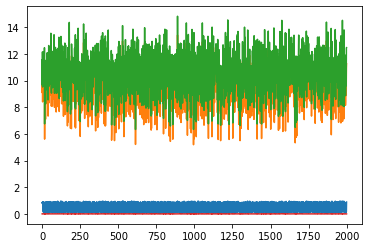

In [55]:
import tensorflow as tf
import evidential_deep_learning as edl
import numpy as np

# Example Data: Adjust according to your real data
#X_train = np.random.rand(1000, 9)  # 1000 samples, 9 features
#y_train = np.random.rand(1000, 1)  # 1000 samples, 1 target value

#X_test = np.random.rand(200, 9)  # Test set, 200 samples, 9 features

# Model Definition
model = tf.keras.Sequential([
    tf.keras.layers.InputLayer(input_shape=(8,)),
    tf.keras.layers.Dense(32, activation="relu"),
    tf.keras.layers.Dense(32, activation="relu"),
    edl.layers.DenseNormalGamma(1),  # Output layer for evidential regression
])

# Custom loss function
def EvidentialRegressionLoss(true, pred):
    return edl.losses.EvidentialRegression(true, pred, coeff=1e-2)

# Compile model
model.compile(optimizer=tf.keras.optimizers.Adam(5e-4), loss=EvidentialRegressionLoss)

# Fit the model
model.fit(X_train, y_train, batch_size=100, epochs=50)

# Make predictions
y_pred = model(X_test)

# If you want to plot the predictions
import matplotlib.pyplot as plt
plt.plot(y_pred.numpy())  # Convert tensor to numpy for plotting if necessary
plt.show()

In [57]:
y_test

,Medical Cost
0,0.824914
1,0.760608
2,0.869827
3,0.818766
4,0.911445
...,...
1995,0.163964
1996,0.105311
1997,0.159146
1998,0.169317


In [68]:
pred_df = pd.DataFrame(y_pred.numpy())


means = pred_df[0]
uncertainty = pred_df[3]
predictions = pd.DataFrame({'Mean':means, 'Uncertainty':uncertainty})
predictions['Medical Cost'] = y_test
predictions

,Mean,Uncertainty,Medical Cost
0,0.826192,0.005546,0.824914
1,0.780373,0.003355,0.760608
2,0.893853,0.002319,0.869827
3,0.824740,0.010333,0.818766
4,0.913946,0.002693,0.911445
...,...,...,...
1995,0.166402,0.002720,0.163964
1996,0.125017,0.003257,0.105311
1997,0.141891,0.003038,0.159146
1998,0.177849,0.002600,0.169317


0.31368181818181823

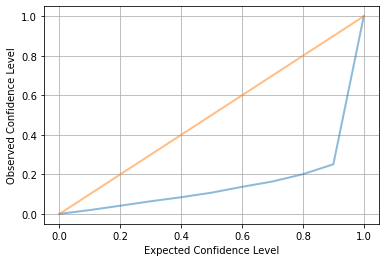

In [69]:
def qce(test_predictions, n_quantiles, n_bins, filename):
  quantiles = np.linspace(0, 1, n_quantiles+1)

  df = test_predictions.sort_values('Uncertainty')

  # Variance ranges for binning
  cutoffs = np.linspace(df['Uncertainty'].iloc[0],
                        df['Uncertainty'].iloc[len(df)-1],
                        n_bins+1)

  error = 0.0
  observed = []

  # For each confidence level
  for p in quantiles:
    bin_freqs = [0 for _ in range(n_bins)]
    bin_counts = [0 for _ in range(n_bins)]
    i = 0
    # For each prediction
    for j in range(len(df)):
      point = df.iloc[j]
      mu = point['Mean']
      s = point['Uncertainty']
      y = point['Medical Cost']

      # Place point in appropriate bin
      if s > cutoffs[i+1]:
        i += 1
      bin_counts[i] += 1

      # Calculate confidence interval
      z = sp.stats.norm.ppf((1 + p) / 2)
      if np.abs(mu - y) <= z * s:
        bin_freqs[i] += 1

    freq = [bin_freqs[i]/bin_counts[i] for i,_ in enumerate(bin_freqs)]
    qce = sum(bin_counts[i] * np.abs(freq[i] - p) for i,_ in enumerate(freq))
    empirical = sum(bin_counts[i] * freq[i] for i,_ in enumerate(freq))
    observed.append(empirical / len(df))
    error += (qce / len(df))

  error = error / (n_quantiles+1)

  if filename == None:
    return error

  fig, ax = plt.subplots()
  ax.plot(quantiles, observed, linewidth=2, alpha=.5)
  ax.plot(quantiles, quantiles, linewidth=2, alpha=.5)

  ax.set_xlabel(r'Expected Confidence Level')
  ax.set_ylabel(r'Observed Confidence Level')
  ax.grid()

  plt.savefig(filename)
  return error


qce(predictions, 10, 10, "dropout_calibration_plot")


Epoch 1/20
10/10 [==============================] - 2s 6ms/step - loss: 8.2044
Epoch 2/20
10/10 [==============================] - 0s 6ms/step - loss: 7.5536
Epoch 3/20
10/10 [==============================] - 0s 4ms/step - loss: 7.0339
Epoch 4/20
10/10 [==============================] - 0s 5ms/step - loss: 6.5810
Epoch 5/20
10/10 [==============================] - 0s 4ms/step - loss: 6.1355
Epoch 6/20
10/10 [==============================] - 0s 3ms/step - loss: 5.7080
Epoch 7/20
10/10 [==============================] - 0s 3ms/step - loss: 5.2717
Epoch 8/20
10/10 [==============================] - 0s 3ms/step - loss: 4.8497
Epoch 9/20
10/10 [==============================] - 0s 3ms/step - loss: 4.4743
Epoch 10/20
10/10 [==============================] - 0s 3ms/step - loss: 4.2039
Epoch 11/20
10/10 [==============================] - 0s 3ms/step - loss: 4.0667
Epoch 12/20
10/10 [==============================] - 0s 5ms/step - loss: 4.0270
Epoch 13/20
10/10 [==============================

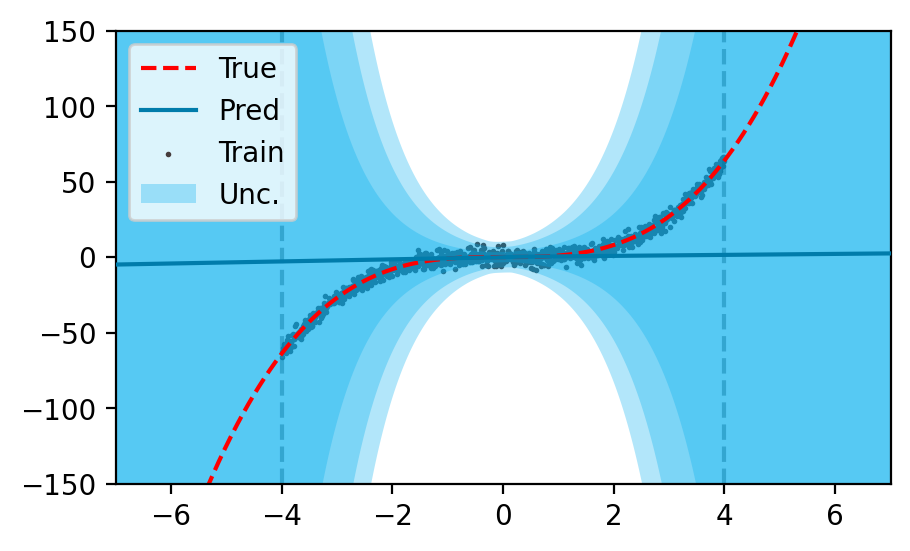

In [ ]:
import functools
import numpy as np
import matplotlib.pyplot as plt

import evidential_deep_learning as edl
import tensorflow as tf


def main():
    # Create some training and testing data
    x_train, y_train = my_data(-4, 4, 1000)
    x_test, y_test = my_data(-7, 7, 1000, train=False)

    # Define our model with an evidential output
    model = tf.keras.Sequential([
        tf.keras.layers.Dense(64, activation="relu"),
        tf.keras.layers.Dense(64, activation="relu"),
        edl.layers.DenseNormalGamma(1),
    ])

    # Custom loss function to handle the custom regularizer coefficient
    def EvidentialRegressionLoss(true, pred):
        return edl.losses.EvidentialRegression(true, pred, coeff=1e-2)

    # Compile and fit the model!
    model.compile(
        optimizer=tf.keras.optimizers.Adam(5e-4),
        loss=EvidentialRegressionLoss)
    model.fit(x_train, y_train, batch_size=100, epochs=20
              )

    # Predict and plot using the trained model
    y_pred = model(x_test)
    plot_predictions(x_train, y_train, x_test, y_test, y_pred)

    # Done!!


#### Helper functions ####
def my_data(x_min, x_max, n, train=True):
    x = np.linspace(x_min, x_max, n)
    x = np.expand_dims(x, -1).astype(np.float32)

    sigma = 3 * np.ones_like(x) if train else np.zeros_like(x)
    y = x**3 + np.random.normal(0, sigma).astype(np.float32)

    return x, y

def plot_predictions(x_train, y_train, x_test, y_test, y_pred, n_stds=4, kk=0):
    x_test = x_test[:, 0]
    mu, v, alpha, beta = tf.split(y_pred, 4, axis=-1)
    mu = mu[:, 0]
    var = np.sqrt(beta / (v * (alpha - 1)))
    var = np.minimum(var, 1e3)[:, 0]  # for visualization

    plt.figure(figsize=(5, 3), dpi=200)
    plt.scatter(x_train, y_train, s=1., c='#463c3c', zorder=0, label="Train")
    plt.plot(x_test, y_test, 'r--', zorder=2, label="True")
    plt.plot(x_test, mu, color='#007cab', zorder=3, label="Pred")
    plt.plot([-4, -4], [-150, 150], 'k--', alpha=0.4, zorder=0)
    plt.plot([+4, +4], [-150, 150], 'k--', alpha=0.4, zorder=0)
    for k in np.linspace(0, n_stds, 4):
        plt.fill_between(
            x_test, (mu - k * var), (mu + k * var),
            alpha=0.3,
            edgecolor=None,
            facecolor='#00aeef',
            linewidth=0,
            zorder=1,
            label="Unc." if k == 0 else None)
    plt.gca().set_ylim(-150, 150)
    plt.gca().set_xlim(-7, 7)
    plt.legend(loc="upper left")
    plt.show()


if __name__ == "__main__":
    main()